<a href="https://colab.research.google.com/github/imkrish513/124/blob/main/FinalPredicter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Aim:** Stock Market Prediction & Forecasting using Stacked LSTM

<br>


## Loading Libraries & Importing Dataset

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import array

In [ ]:
!pip install -q yfinance

In [ ]:
import yfinance as yf
yf.pdr_override()
from datetime import datetime

from pandas_datareader import data as pdr

data = pdr.get_data_yahoo('AMD', start='2021-04-10', end='2023-01-25', interval = '60m')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-04-12 09:30:00,81.919998,82.108803,80.910004,81.550003,81.550003,8150238
2021-04-12 10:30:00,81.550003,81.949203,80.929802,81.709999,81.709999,4942307
2021-04-12 11:30:00,81.720001,81.919998,80.739998,80.894897,80.894897,5620004
2021-04-12 12:30:00,80.900002,81.199997,79.675003,79.709999,79.709999,9302606
2021-04-12 13:30:00,79.699997,79.709999,78.550003,78.565002,78.565002,12916687


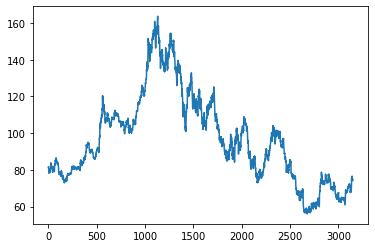

In [ ]:
temp = data.reset_index()['Close']
plt.plot(temp)

## Data Transformation using Min-Max-Scaler

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-04-12 09:30:00,81.919998,82.108803,80.910004,81.550003,81.550003,8150238
2021-04-12 10:30:00,81.550003,81.949203,80.929802,81.709999,81.709999,4942307
2021-04-12 11:30:00,81.720001,81.919998,80.739998,80.894897,80.894897,5620004
2021-04-12 12:30:00,80.900002,81.199997,79.675003,79.709999,79.709999,9302606
2021-04-12 13:30:00,79.699997,79.709999,78.550003,78.565002,78.565002,12916687


In [ ]:
temp.shape

(3149,)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
temp = scaler.fit_transform(np.array(temp).reshape(-1,1))

In [ ]:
temp.shape

(3149, 1)

## Train Test Split

In [ ]:
# Doing train test split (70-30) sequencially 
data = data.sort_values(by="Datetime")
ntrain = int(len(temp)*0.7)
train, test = temp[0:ntrain,:], temp[ntrain:len(temp),:1]

# Convert array of values to dataset matrix
def dataset(df,time_step=1):
    dx,dy = [],[]
    for i in range(len(df)-time_step-1):
        dx.append(df[i:(i+time_step),0])
        dy.append(df[i+time_step,0])
    return np.array(dx),np.array(dy)

In [ ]:
# Reshaping the Dataset in 3 parts
time_step = 50
x_train, y_train = dataset(train,time_step)
x_test, y_test = dataset(test,time_step)

# Checking the Shape
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(2153, 50) (894, 50)
(2153,) (894,)


In [ ]:
# Reshaping the data to numpy array as per requirement for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

# Checking the Shape
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(2153, 50, 1) (894, 50, 1)
(2153,) (894,)


## Applying LSTM Model

In [ ]:
model = Sequential()
model.add(LSTM(64,return_sequences = True,input_shape = (50,1)))
model.add(LSTM(32))
model.add(Dense(16,activation='relu'))
model.add(Dense(1))

In [ ]:
model.summary()
model.compile(loss='mse',optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min",patience = 3,restore_best_weights = True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs = 15,batch_size = 32,verbose=1,callbacks =[earlystopping])

Epoch 1/15
68/68 [==============================] - 13s 73ms/step - loss: 0.0317 - val_loss: 0.0021
Epoch 2/15
68/68 [==============================] - 4s 58ms/step - loss: 0.0011 - val_loss: 8.5124e-04
Epoch 3/15
68/68 [==============================] - 5s 79ms/step - loss: 0.0010 - val_loss: 7.9210e-04
Epoch 4/15
68/68 [==============================] - 4s 58ms/step - loss: 0.0010 - val_loss: 7.1608e-04
Epoch 5/15
68/68 [==============================] - 4s 63ms/step - loss: 9.8774e-04 - val_loss: 6.6167e-04
Epoch 6/15
68/68 [==============================] - 5s 74ms/step - loss: 9.0017e-04 - val_loss: 6.0030e-04
Epoch 7/15
68/68 [==============================] - 4s 60ms/step - loss: 8.5650e-04 - val_loss: 5.0499e-04
Epoch 8/15
68/68 [==============================] - 5s 74ms/step - loss: 8.3770e-04 - val_loss: 5.0162e-04
Epoch 9/15
68/68 [==============================] - 6s 84ms/step - loss: 8.4516e-04 - val_loss: 4.7352e-04
Epoch 10/15
68/68 [==============================] - 4s 

## Prediction on Test Data

In [ ]:
yp_train = model.predict(x_train)
yp_test = model.predict(x_test)

28/28 [==============================] - 1s 18ms/step


## Inverse Transformation 

In [ ]:
yp_train = scaler.inverse_transform(yp_train)
yp_test = scaler.inverse_transform(yp_test)

In [ ]:
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
print(yp_train.shape,yp_test.shape)

(2153, 50, 1) (894, 50, 1)
(2153,) (894,)
(2153, 1) (894, 1)


## Evaluating the Model using metrics

In [ ]:
# MAE
print("MAE for Train Data: {}".format(mean_absolute_error(y_train,yp_train)))
print("MAE for Test Data: {}\n".format(mean_absolute_error(y_test,yp_test)))

# MSE
print("MSE for Train Data: {}".format(mean_squared_error(y_train,yp_train)))
print("MSE for Test Data: {}\n".format(mean_squared_error(y_test,yp_test)))

MAE for Train Data: 106.98425539831952
MAE for Test Data: 75.3068852193878

MSE for Train Data: 11912.2845586964
MSE for Test Data: 5829.085448790771



## Plotting the Predicted Output

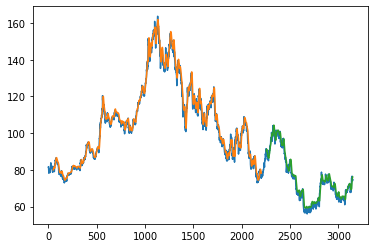

In [ ]:
# Shifting train predictions for plotting
look_back=50
yp_train_plot = np.empty_like(temp)
yp_train_plot[:,:] = np.nan
yp_train_plot[look_back:len(yp_train)+look_back,:] = yp_train

# Shifting test predictions for plotting
yp_test_plot = np.empty_like(temp)
yp_test_plot[:, :] = np.nan
yp_test_plot[len(yp_train)+(look_back*2)+1:len(temp)-1,:] = yp_test

# Plotting predictions
plt.plot(scaler.inverse_transform(temp))
plt.plot(yp_train_plot)
plt.plot(yp_test_plot)
plt.show()

> **Orange Line: Train Data**
>
> **Green Line: Test Data**

## Predicting & Forecasting for next 30 Days

In [ ]:
x_input = test[(len(test)-500):].reshape(1,-1) # We take last 50 days data from test data for our future prediction 
temp_input = list(x_input)
temp_input = temp_input[0].tolist() # Test data

In [ ]:
# Predictions for next 30 days

lstm_op = []
n_steps = 500
i = 0
while(i < 50):
    if(len(temp_input)>500):
        x_input=np.array(temp_input[1:])
        
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yp = model.predict(x_input, verbose=0)
        print("{} hour output {}".format(i,yp))
        
        temp_input.extend(yp[0].tolist())
        temp_input=temp_input[1:]
        lstm_op.extend(yp.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,n_steps,1))
        yp = model.predict(x_input,verbose=0)
        
        temp_input.extend(yp[0].tolist())
        lstm_op.extend(yp.tolist())
        i=i+1

1 day output [[0.18487163]]
2 day output [[0.18508919]]
3 day output [[0.18568839]]
4 day output [[0.18655361]]
5 day output [[0.18759924]]
6 day output [[0.18876408]]
7 day output [[0.1900057]]
8 day output [[0.19129552]]
9 day output [[0.19261445]]
10 day output [[0.19395025]]
11 day output [[0.19529517]]
12 day output [[0.19664426]]
13 day output [[0.19799463]]
14 day output [[0.19934441]]
15 day output [[0.20069252]]
16 day output [[0.20203833]]
17 day output [[0.20338143]]
18 day output [[0.20472156]]
19 day output [[0.20605853]]
20 day output [[0.20739229]]
21 day output [[0.20872268]]
22 day output [[0.2100497]]
23 day output [[0.21137327]]
24 day output [[0.21269338]]
25 day output [[0.21401002]]
26 day output [[0.2153232]]
27 day output [[0.21663287]]
28 day output [[0.21793918]]
29 day output [[0.21924208]]
30 day output [[0.22054166]]
31 day output [[0.22183795]]
32 day output [[0.22313105]]
33 day output [[0.22442101]]
34 day output [[0.22570796]]
35 day output [[0.22699192

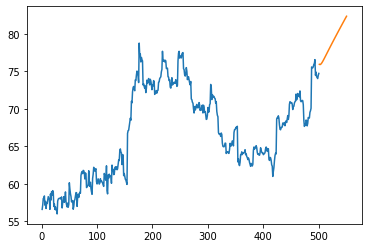

In [ ]:
day_new = np.arange(1,501)
day_pred=np.arange(501,501+50)

plt.plot(day_new,scaler.inverse_transform(temp[len(temp)-500:]))
plt.plot(day_pred,scaler.inverse_transform(lstm_op))

## Conclusion
> #### Used Stacked LSTM for Stock Market Prediction & Done Forecasting for next 30 days.